In [ ]:
!pip install xarray
!pip install xarray[io]

In [1]:
import os
import io
import pathlib
import numpy
import pandas
import seaborn
from pathlib import Path
from matplotlib import pyplot as plt, ticker
import matplotlib
from matplotlib.colors import LogNorm
import datetime
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import multiprocessing
import configparser
import subprocess
import xarray
import itertools
import math

In [2]:
def parallel_MCTrans(config_path, sweep_key, sweep_value, run_idx):
    MCTrans_path = '/home/agargone/Alex_MCTrans/MCTrans/MCTrans++'
    # !$MCTrans_path $config_path
    subprocess.run([MCTrans_path, f'{config_path}.config'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    interim_results_df = pandas.DataFrame()
    interim_results_df.at[0,'Run Index'] = run_idx
    interim_results_df.at[0,'Study Sweep Variable'] = sweep_key
    interim_results_df.at[0,'t'] = sweep_value
    interim_results_df.at[0,'FilePath'] = config_path
    if Path(f'{config_path}.nc').is_file():
        data_set = xarray.open_dataset(f'{config_path}.nc')
        data_set_df = data_set.to_dataframe()
    else:
        data_set_df = pandas.DataFrame()
    interim_results_df = pandas.concat([interim_results_df, data_set_df],axis=1)
    return interim_results_df

In [30]:
def parallel_MCTrans_multi_variable(df, run_idx):
    MCTrans_path = '/home/agargone/Alex_MCTrans/MCTrans/MCTrans++'
    # !$MCTrans_path $config_path
    df.reset_index(inplace=True)
    config_path = df.at[0,'FilePath']
    # if Path(f'{config_path}.config').is_file():
        # print('config file')

    # print(config_path)
    # config_path2 =  f'{config_path}.config'
    # !$MCTrans_path $config_path2
    
    subprocess.run([MCTrans_path, f'{config_path}.config'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    interim_results_df = pandas.DataFrame()
    interim_results_df.at[0,'Run Index'] = run_idx
    interim_results_df.at[0,'Sweep_parameters_name_1'] = df.at[0,'param_1_name']
    interim_results_df.at[0,'Sweep_parameters_name_2'] = df.at[0,'param_2_name']
    interim_results_df.at[0,'Sweep_parameters_name_3'] = df.at[0,'param_3_name']
    interim_results_df.at[0,'Sweep_parameters_name_4'] = df.at[0,'param_4_name']
    interim_results_df.at[0,'Sweep_parameters_name_5'] = df.at[0,'param_5_name']
    interim_results_df.at[0,'Sweep_parameters_value_1'] = df.at[0,'param_1']
    interim_results_df.at[0,'Sweep_parameters_value_2'] = df.at[0,'param_2']
    interim_results_df.at[0,'Sweep_parameters_value_3'] = df.at[0,'param_3']
    interim_results_df.at[0,'Sweep_parameters_value_4'] = df.at[0,'param_4']
    interim_results_df.at[0,'Sweep_parameters_value_5'] = df.at[0,'param_5']
    interim_results_df.at[0,'FilePath'] = config_path
    if Path(f'{config_path}.nc').is_file():
        # print('FILE')
        data_set = xarray.open_dataset(f'{config_path}.nc')
        data_set_df = data_set.to_dataframe()
    else:
        # print('SKIP')
        data_set_df = pandas.DataFrame()
    interim_results_df = pandas.concat([interim_results_df, data_set_df],axis=1)
    return interim_results_df

In [4]:
def parallel_MCTrans_multi_variable_read_data_only(df, run_idx):
    df.reset_index(inplace=True)
    config_path = df.at[0,'FilePath']
    interim_results_df = pandas.DataFrame()
    interim_results_df.at[0,'Run Index'] = run_idx
    interim_results_df.at[0,'Sweep_parameters_name_1'] = df.at[0,'param_1_name']
    interim_results_df.at[0,'Sweep_parameters_name_2'] = df.at[0,'param_2_name']
    interim_results_df.at[0,'Sweep_parameters_name_3'] = df.at[0,'param_3_name']
    interim_results_df.at[0,'Sweep_parameters_name_4'] = df.at[0,'param_4_name']
    interim_results_df.at[0,'Sweep_parameters_name_5'] = df.at[0,'param_5_name']
    interim_results_df.at[0,'Sweep_parameters_value_1'] = df.at[0,'param_1']
    interim_results_df.at[0,'Sweep_parameters_value_2'] = df.at[0,'param_2']
    interim_results_df.at[0,'Sweep_parameters_value_3'] = df.at[0,'param_3']
    interim_results_df.at[0,'Sweep_parameters_value_4'] = df.at[0,'param_4']
    interim_results_df.at[0,'Sweep_parameters_value_5'] = df.at[0,'param_5']
    interim_results_df.at[0,'FilePath'] = config_path
    if Path(f'{config_path}.nc').is_file():
        data_set = xarray.open_dataset(f'{config_path}.nc')
        data_set_df = data_set.to_dataframe()
    else:
        data_set_df = pandas.DataFrame()
    interim_results_df = pandas.concat([interim_results_df, data_set_df],axis=1)
    return interim_results_df

In [5]:
def multi_variable_config_init_worker(_Sweep_parameters_1, _Sweep_parameters_2, _Sweep_parameters_3, _Sweep_parameters_4, _Sweep_parameters_5, _base_config, _home_directory_filepath, _Study_name, _Study_sweep_variable):
    global Sweep_parameters_1, Sweep_parameters_2, Sweep_parameters_3, Sweep_parameters_4, Sweep_parameters_5, base_config, home_directory_filepath, Study_name, Study_sweep_variable
    Sweep_parameters_1, Sweep_parameters_2, Sweep_parameters_3, Sweep_parameters_4, Sweep_parameters_5, base_config, home_directory_filepath, Study_name, Study_sweep_variable = _Sweep_parameters_1, _Sweep_parameters_2, _Sweep_parameters_3, _Sweep_parameters_4, _Sweep_parameters_5, _base_config, _home_directory_filepath, _Study_name, _Study_sweep_variable

In [6]:
def multi_variable_config_writer(idx_tuple):
    param_1 = float(Sweep_parameters_1[int(idx_tuple[1][0])])
    param_2 = float(Sweep_parameters_2[int(idx_tuple[1][1])])
    param_3 = float(Sweep_parameters_3[int(idx_tuple[1][2])])
    param_4 = float(Sweep_parameters_4[int(idx_tuple[1][3])])
    param_5 = float(Sweep_parameters_5[int(idx_tuple[1][4])])
    run_idx_identifier = idx_tuple[0] 
    
    base_config['configuration'][Sweep_parameters_name_1] = str(param_1)
    base_config['configuration'][Sweep_parameters_name_2] = str(param_2)
    base_config['configuration'][Sweep_parameters_name_3] = str(param_3)
    base_config['configuration'][Sweep_parameters_name_4] = str(param_4)
    base_config['configuration'][Sweep_parameters_name_5] = str(param_5)
    base_config['configuration']['PlasmaRadiusMax'] = str(param_2-0.01)
    specific_output_filepath = pathlib.Path(output_filepath) / 'configs_and_outputs' / f'{Study_sweep_variable}_{str(param_1)}_{str(param_2)}_{str(param_3)}_{str(param_4)}_{str(param_5)}_run_{run_idx_identifier}'
    specific_output_filepath.mkdir(parents=True, exist_ok=True)
    base_config['algorithm']['AsciiOutputFile'] = f'"{specific_output_filepath}/{Study_name}_{Study_sweep_variable}_{str(param_1)}_{str(param_2)}_{str(param_3)}_{str(param_4)}_{str(param_5)}_run_{run_idx_identifier}.out"'
    base_config['algorithm']['NetcdfOutput'] = f'"{specific_output_filepath}/{Study_name}_{Study_sweep_variable}_{str(param_1)}_{str(param_2)}_{str(param_3)}_{str(param_4)}_{str(param_5)}_run_{run_idx_identifier}.nc"'
    filepath = f'{specific_output_filepath}/{Study_name}_{Study_sweep_variable}_{str(param_1)}_{str(param_2)}_{str(param_3)}_{str(param_4)}_{str(param_5)}_run_{run_idx_identifier}' #.config'

    with open(f'{specific_output_filepath}/{Study_name}_{Study_sweep_variable}_{str(param_1)}_{str(param_2)}_{str(param_3)}_{str(param_4)}_{str(param_5)}_run_{run_idx_identifier}.config', 'w') as configfile:
        configfile.write('Mode = "SteadyState"\n\n')# Pre-header
        base_config.write(configfile)
    return run_idx_identifier, filepath, param_1, param_2, param_3, param_4, param_5
    

In [17]:
Project_study_name = 'Geordi_studies'
Study_name = 'Voltage_WallRadius_PlasmaLength_CenterCellField_ElectronDensity_DD_sweep_study'
Study_sweep_variable = 'V_WR_PL_CCF_ED'

# home_directory_filepath = '/home/agargone/Alex_MCTrans'
home_directory_filepath = '/tmp/Alex_MCTrans'

base_config = configparser.ConfigParser()
base_config.optionxform = str  # Preserve case sensitivity

base_config['algorithm'] = {
    'UseAmbipolarPhi': 'true',
    'IncludeChargeExchangeLosses': 'true',
    'AsciiOutputFile': '"{}_{}.out"'.format(Study_name, Study_sweep_variable),
    'NetcdfOutput': '"{}_{}.nc"'.format(Study_name, Study_sweep_variable),
}

base_config['configuration'] = {
    'IonSpecies': '"Deuterium"',
    # 'InitialMach': '4.0',
    # 'InitialTemp': '0.6',
    'IonToElectronTemperatureRatio': '1.0',
    'Zeff': '1.0',
    'ElectronDensity': '0.1',
    'CentralCellField': '0.45',
    'ThroatField': '4.5',
    'Voltage': '30000.0',
    'PlasmaRadiusMin': '0.0075',
    'PlasmaRadiusMax': '0.055',
    'WallRadius': '0.06',
    'PlasmaLength': '0.1',
    'ExhaustRadius': '0.0075',
    'AuxiliaryHeating': '0.0',
    'IncludeAlphaHeating': 'true',
    'ReportNuclearDiagnostics': 'true'
}


config_file_paths_df = pandas.DataFrame()


In [18]:
start_time0 = datetime.datetime.now()
# Sweep_parameters_1 = [(1e1 + i*6000) for i in range(2)]
Sweep_parameters_1 = [(100e3 + i*100e3) for i in range(11)]
Sweep_parameters_1 = numpy.round(Sweep_parameters_1,decimals=6)
Sweep_parameters_name_1 = 'Voltage'
len_Swp1 = range(len(Sweep_parameters_1))

# Sweep_parameters_2 = [(0.06 + i*0.05) for i in range(2)]
Sweep_parameters_2 = [(0.06 + i*0.05) for i in range(21)]
Sweep_parameters_2 = numpy.round(Sweep_parameters_2,decimals=6)
Sweep_parameters_name_2 = 'WallRadius'
len_Swp2 = range(len(Sweep_parameters_2))

# Sweep_parameters_3 = [(0.1 + i*0.1) for i in range(2)]
Sweep_parameters_3 = [(0.1 + i*0.1) for i in range(51)]
Sweep_parameters_3 = numpy.round(Sweep_parameters_3,decimals=6)
Sweep_parameters_name_3 = 'PlasmaLength'
len_Swp3 = range(len(Sweep_parameters_3))

Sweep_parameters_4 = [0.225, 0.45, 0.9]
Sweep_parameters_name_4 = 'CentralCellField'
len_Swp4 = range(len(Sweep_parameters_4))

Sweep_parameters_5 = [0.01, 0.1, 1.0, 10.0]
Sweep_parameters_name_5 = 'ElectronDensity'
len_Swp5 = range(len(Sweep_parameters_5))

output_filepath = pathlib.Path('/tmp/Alex_MCTrans') / Project_study_name / Study_name
# output_filepath = pathlib.Path('Geordi_studies') / Study_name
output_filepath.mkdir(parents=True, exist_ok=True)


sweep_combos = enumerate(itertools.product(len_Swp1, len_Swp2, len_Swp3, len_Swp4,len_Swp5))
total = len(Sweep_parameters_1)*len(Sweep_parameters_2)*len(Sweep_parameters_3)*len(Sweep_parameters_4)*len(Sweep_parameters_5)
print(f'total: {total}')
n_workers = int(multiprocessing.cpu_count()-1)
chunksize = max(1, math.floor(total / (n_workers * 300)))

print(f'chunksize: {chunksize}')

filepaths = numpy.empty(total, dtype=object)
col_run_idx = numpy.empty(total, dtype=float)
col_p1 = numpy.empty(total, dtype=float)
col_p2 = numpy.empty(total, dtype=float)
col_p3 = numpy.empty(total, dtype=float)
col_p4 = numpy.empty(total, dtype=float)
col_p5 = numpy.empty(total, dtype=float)



with ProcessPoolExecutor(max_workers=n_workers, initializer=multi_variable_config_init_worker, initargs=(Sweep_parameters_1, Sweep_parameters_2, Sweep_parameters_3, Sweep_parameters_4, Sweep_parameters_5, base_config, home_directory_filepath, Study_name, Study_sweep_variable)) as executor:
    for run_idx, path, p1, p2, p3, p4, p5 in executor.map(multi_variable_config_writer, sweep_combos, chunksize=chunksize):
        filepaths[run_idx] = path
        col_run_idx[run_idx] = run_idx
        col_p1[run_idx] = p1
        col_p2[run_idx] = p2
        col_p3[run_idx] = p3
        col_p4[run_idx] = p4
        col_p5[run_idx] = p5

config_file_paths_df = pandas.DataFrame()
config_file_paths_df['FilePath'] = filepaths
config_file_paths_df['run_idx'] = col_run_idx
config_file_paths_df['param_1'] = col_p1
config_file_paths_df['param_1_name'] = Sweep_parameters_name_1
config_file_paths_df['param_2'] = col_p2
config_file_paths_df['param_2_name'] = Sweep_parameters_name_2
config_file_paths_df['param_3'] = col_p3
config_file_paths_df['param_3_name'] = Sweep_parameters_name_3
config_file_paths_df['param_4'] = col_p4
config_file_paths_df['param_4_name'] = Sweep_parameters_name_4
config_file_paths_df['param_5'] = col_p5
config_file_paths_df['param_5_name'] = Sweep_parameters_name_5
print(config_file_paths_df)
config_file_paths_df.to_csv(f'{output_filepath}/config_file_paths_df.csv',index=False)

end_time0 = datetime.datetime.now()
print("Done with MCTrans Config File Generator! With execution time: {} s".format(end_time0 - start_time0))

total: 141372
chunksize: 2
                                                 FilePath   run_idx  \
0       /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...       0.0   
1       /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...       1.0   
2       /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...       2.0   
3       /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...       3.0   
4       /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...       4.0   
...                                                   ...       ...   
141367  /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...  141367.0   
141368  /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...  141368.0   
141369  /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...  141369.0   
141370  /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...  141370.0   
141371  /tmp/Alex_MCTrans/Geordi_studies/Voltage_WallR...  141371.0   

          param_1 param_1_name  param_2 param_2_name  param_3  param_3_name  \
0        100000.0      Voltage     0.06  

In [31]:
### READ & RUN MCTRANS DATA ###
###############################
start_time1 = datetime.datetime.now()

if Path(f'{output_filepath}/config_file_paths_df.csv').is_file():
    config_file_paths_df = pandas.read_csv(Path(f'{output_filepath}/config_file_paths_df.csv'))

n_workers = min(len(config_file_paths_df), int(multiprocessing.cpu_count()-1))

print(f'Running with {n_workers} workers')

print(f'Length of sweep: {len(config_file_paths_df)}')

futures_list = []
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    futures = {executor.submit(parallel_MCTrans_multi_variable, config_file_paths_df.iloc[[t]], t): t for t in range(len(config_file_paths_df))}
    # futures = {executor.submit(parallel_MCTrans, config_file_paths_df.at[t,'FilePath'], Study_sweep_variable, Sweep_parameters[t], t): t for t in range(len(config_file_paths_df))}

    for future in as_completed(futures):
        try:
            futures_list.append(future)
            # print(f"Finished run {futures[future]}/{len(config_file_paths_df)-1}")

        except Exception as e:
            print(f"Error in iteration {futures[future]}: {e}")
        
end_time1 = datetime.datetime.now()
print("Done with MCTrans Calcs! With execution time: {} s".format(end_time1 - start_time1))

Running with 191 workers
Length of sweep: 141372
Done with MCTrans Calcs! With execution time: 0:09:41.551347 s


In [ ]:
###  READ MCTRANS DATA ONLY ###
###############################
start_time2 = datetime.datetime.now()

if Path(f'{output_filepath}/config_file_paths_df.csv').is_file():
    config_file_paths_df = pandas.read_csv(Path(f'{output_filepath}/config_file_paths_df.csv'))

n_workers = min(len(config_file_paths_df), int(multiprocessing.cpu_count()-1))

print(f'Running with {n_workers} workers')

print(f'Length of sweep: {len(config_file_paths_df)}')

futures_list = []
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    futures = {executor.submit(parallel_MCTrans_multi_variable_read_data_only, config_file_paths_df.iloc[[t]], t): t for t in range(len(config_file_paths_df))}
    for future in as_completed(futures):
        try:
            futures_list.append(future)
        except Exception as e:
            print(f"Error in iteration {futures[future]}: {e}")
        
end_time2 = datetime.datetime.now()
print("Done with MCTrans Calcs! With execution time: {} s".format(end_time2 - start_time2))


In [32]:
check_result = futures_list[141371].result()

print(check_result.columns)
print(check_result)
# print(check_result.RotationPower)

# print(check_result.RhoIon)
# print(check_result.a)
# print(check_result.R_min)
# print(check_result.R_max)
# print(check_result.R_plasma)
# print(check_result.R_wall)
# print(check_result.R_throat)
# print(check_result.RhoIon/check_result.R_wall)
print(check_result.FusionNeutronPower*1e-6)
print(check_result.FusionNeutronPower/(14.1e6/6.241509074460762607e18))
# print(check_result.RotationPower)
# print(check_result.V_plasma)
# print(check_result.L_plasma*(check_result.R_max**2-check_result.R_min**2)*numpy.pi)
# print(check_result.Voltage)
# print(check_result.IonCollisionality)


Index(['Run Index', 'Sweep_parameters_name_1', 'Sweep_parameters_name_2',
       'Sweep_parameters_name_3', 'Sweep_parameters_name_4',
       'Sweep_parameters_name_5', 'Sweep_parameters_value_1',
       'Sweep_parameters_value_2', 'Sweep_parameters_value_3',
       'Sweep_parameters_value_4', 'Sweep_parameters_value_5', 'FilePath'],
      dtype='object')
   Run Index Sweep_parameters_name_1 Sweep_parameters_name_2  \
0   132031.0                 Voltage              WallRadius   

  Sweep_parameters_name_3 Sweep_parameters_name_4 Sweep_parameters_name_5  \
0            PlasmaLength        CentralCellField         ElectronDensity   

   Sweep_parameters_value_1  Sweep_parameters_value_2  \
0                 1100000.0                      0.31   

   Sweep_parameters_value_3  Sweep_parameters_value_4  \
0                       3.8                      0.45   

   Sweep_parameters_value_5                                           FilePath  
0                      10.0  /tmp/Alex_MCTrans/

AttributeError: 'DataFrame' object has no attribute 'FusionNeutronPower'

In [33]:
start_time3 = datetime.datetime.now()
results_df = pandas.DataFrame()

results_df = pandas.concat([future_list.result() for future_list in futures_list])
results_df.sort_values(by='Run Index', inplace=True)
results_df.reset_index(inplace=True,drop=True)
results_df.to_csv(f'{output_filepath}/sweep_results.csv',index=False) 

end_time3 = datetime.datetime.now()
print("Done with MCTrans Result Analysis! With execution time: {} s".format(end_time3 - start_time3))

Done with MCTrans Result Analysis! With execution time: 0:00:26.777414 s


In [34]:
print(results_df.columns)

Index(['Run Index', 'Sweep_parameters_name_1', 'Sweep_parameters_name_2',
       'Sweep_parameters_name_3', 'Sweep_parameters_name_4',
       'Sweep_parameters_name_5', 'Sweep_parameters_value_1',
       'Sweep_parameters_value_2', 'Sweep_parameters_value_3',
       'Sweep_parameters_value_4', 'Sweep_parameters_value_5', 'FilePath',
       'FuelName', 'ZEff', 'IonTemperature', 'ElectronTemperature',
       'IonDensity', 'ElectronDensity', 'R_min', 'R_max', 'R_plasma', 'R_wall',
       'R_throat', 'L_plasma', 'V_plasma', 'B_midplane', 'B_throat', 'RhoIon',
       'a', 'RhoStar', 'AuxiliaryHeating', 'AlphaHeating',
       'AlphaPromptLossRate', 'AlphaPromptHeating', 'AlphaSlowingDown', 'Mach',
       'AlfvenMach', 'Velocity', 'AngularVelocity', 'ViscousHeating',
       'BremsstrahlungLosses', 'CyclotronLosses', 'CXLosses', 'Voltage',
       'JRadial', 'RotationPower', 'ViscousTorque', 'ParallelRotationLosses',
       'CXRotationLosses', 'KineticEnergy', 'ThermalEnergy', 'StoredEnergy',
 

In [36]:
results_df['rho_i_over_R_wall'] = results_df['RhoIon']/results_df['R_wall']
results_df['neutrons_per_second'] = results_df['DDNeutrons']
# results_df['neutrons_per_second'] = results_df['FusionNeutronPower']/(14.1e6/6.241509074460762607e18)
results_df['neutrons_per_second_per_Watt'] = results_df['neutrons_per_second']/results_df['RotationPower']
results_df['Mirror_Ratio'] = results_df['B_throat']/results_df['B_midplane']
results_df['Aspect_Ratio_Ms'] = numpy.sqrt((results_df['a']/results_df['L_plasma'])*numpy.log(1e8))
results_df.to_csv(f'{output_filepath}/sweep_results.csv',index=False) 

In [37]:
print(results_df)

        Run Index Sweep_parameters_name_1 Sweep_parameters_name_2  \
0             0.0                 Voltage              WallRadius   
1             1.0                 Voltage              WallRadius   
2             2.0                 Voltage              WallRadius   
3             3.0                 Voltage              WallRadius   
4             4.0                 Voltage              WallRadius   
...           ...                     ...                     ...   
141367   141367.0                 Voltage              WallRadius   
141368   141368.0                 Voltage              WallRadius   
141369   141369.0                 Voltage              WallRadius   
141370   141370.0                 Voltage              WallRadius   
141371   141371.0                 Voltage              WallRadius   

       Sweep_parameters_name_3 Sweep_parameters_name_4  \
0                 PlasmaLength        CentralCellField   
1                 PlasmaLength        CentralCellField 

In [ ]:
print(output_filepath)

In [ ]:
source_path = f'/tmp/Alex_MCTrans/{Project_study_name}/{Study_name}/'
dest_path = f'/home/agargone/Alex_MCTrans/{Project_study_name}/{Study_name}/'
print(dest_path)
print(f'rclone sync -P --multi-thread-streams 256 {source_path} {dest_path}')
!rclone sync -P --multi-thread-streams 128 $source_path $dest_path

In [ ]:
###  READ PRE-ANAYLZED DATA ###
###############################
if Path(f'{output_filepath}/sweep_results.csv').is_file():
    results_df = pandas.read_csv(f'{output_filepath}/sweep_results.csv')

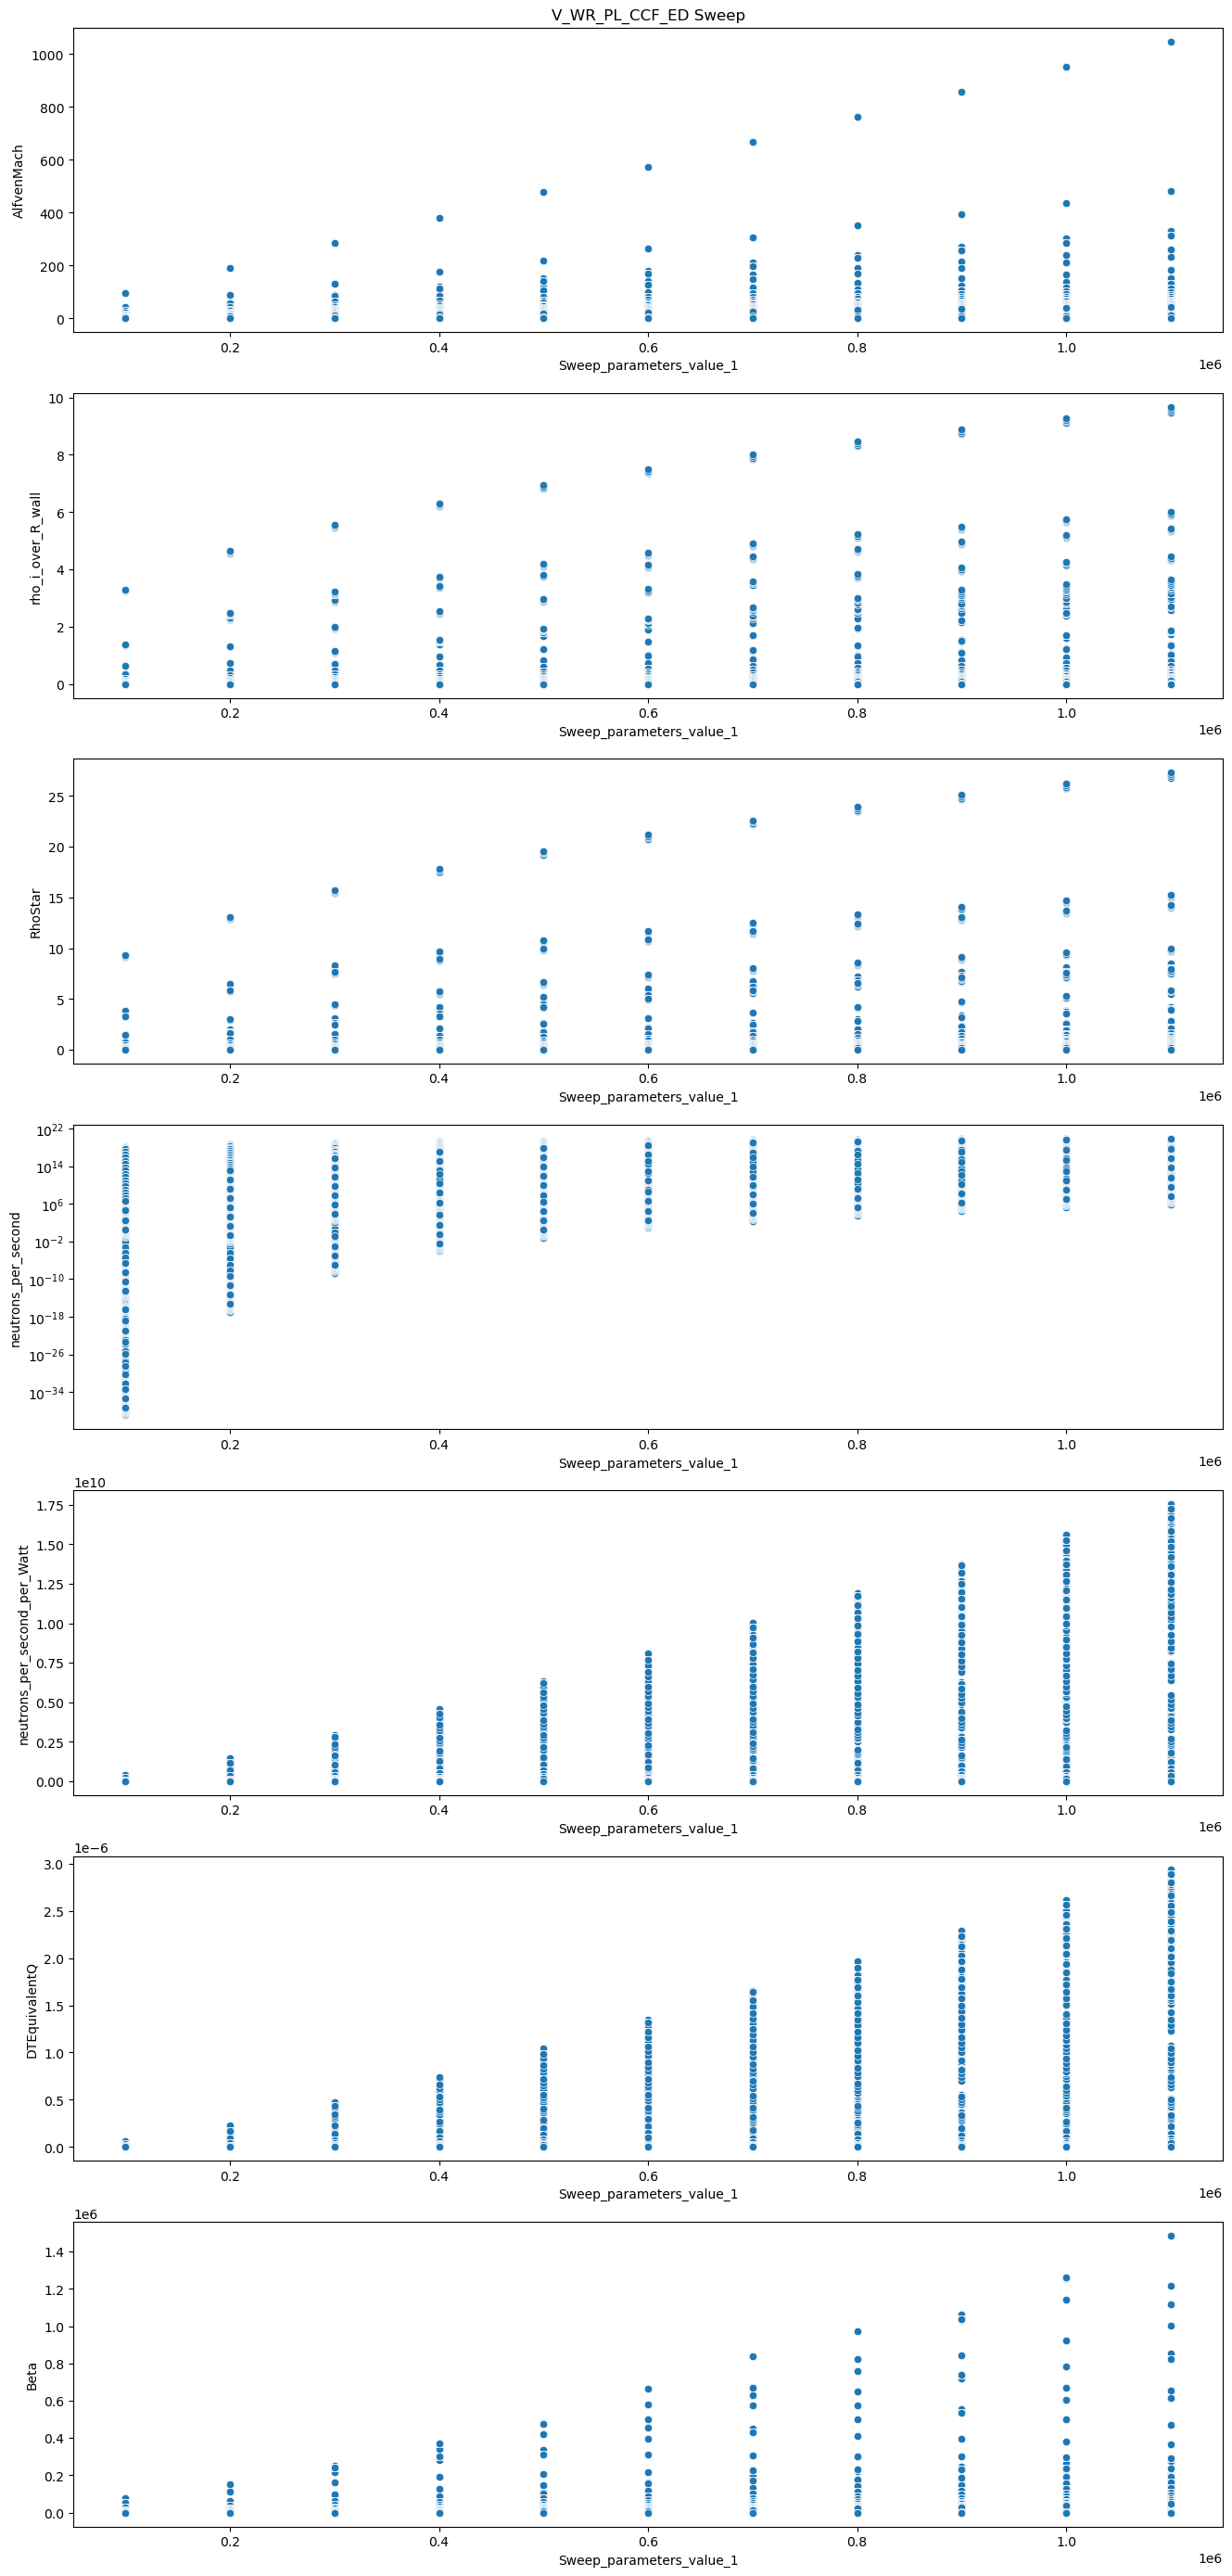

In [39]:
fig, ax = plt.subplots(7,1)
fig.set_figwidth(16)
fig.set_figheight(35)
# plt.suptitle(f'{Study_sweep_variable} Sweep')
ax[0].set_title(f'{Study_sweep_variable} Sweep')
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='AlfvenMach', ax=ax[0])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='rho_i_over_R_wall', ax=ax[1])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='RhoStar', ax=ax[2])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='neutrons_per_second', ax=ax[3])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='neutrons_per_second_per_Watt', ax=ax[4])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='DTEquivalentQ', ax=ax[5])
# seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='ScientificQ', ax=ax[5])
seaborn.scatterplot(data=results_df,x='Sweep_parameters_value_1',y='Beta', ax=ax[6])

ax[3].set_yscale('log')

In [40]:
# print(results_df)
Alfven_filtered_results_df = results_df.where(results_df['AlfvenMach']<=1.25)
Alfven_filtered_results_df.dropna(inplace=True)
# print(Alfven_filtered_results_df)

RhoStar_filtered_results_df = Alfven_filtered_results_df.where(Alfven_filtered_results_df['RhoStar']<=0.1)
RhoStar_filtered_results_df.dropna(inplace=True)
# print(RhoStar_filtered_results_df['IonCollisionality'])

IonCollisionality_filtered_results_df = RhoStar_filtered_results_df.where(RhoStar_filtered_results_df['IonCollisionality']<=1e-3)
IonCollisionality_filtered_results_df.dropna(inplace=True)
# print("IonCollisionality_filtered_results_df")
# print(IonCollisionality_filtered_results_df)

aspect_ratio_filtered_results_df = IonCollisionality_filtered_results_df.where(IonCollisionality_filtered_results_df['Mach']>IonCollisionality_filtered_results_df['Aspect_Ratio_Ms'])
aspect_ratio_filtered_results_df.dropna(inplace=True)
print(aspect_ratio_filtered_results_df)

neutron_1e14_filtered_results_df = aspect_ratio_filtered_results_df.where(aspect_ratio_filtered_results_df['neutrons_per_second']>=1e14)
neutron_1e14_filtered_results_df.dropna(inplace=True)
print(neutron_1e14_filtered_results_df)


        Run Index Sweep_parameters_name_1 Sweep_parameters_name_2  \
1232       1232.0                 Voltage              WallRadius   
1233       1233.0                 Voltage              WallRadius   
1244       1244.0                 Voltage              WallRadius   
1256       1256.0                 Voltage              WallRadius   
1268       1268.0                 Voltage              WallRadius   
...           ...                     ...                     ...   
141341   141341.0                 Voltage              WallRadius   
141352   141352.0                 Voltage              WallRadius   
141353   141353.0                 Voltage              WallRadius   
141364   141364.0                 Voltage              WallRadius   
141365   141365.0                 Voltage              WallRadius   

       Sweep_parameters_name_3 Sweep_parameters_name_4  \
1232              PlasmaLength        CentralCellField   
1233              PlasmaLength        CentralCellField 

In [ ]:
fig, ax = plt.subplots(7,1)
fig.set_figwidth(16)
fig.set_figheight(35)
# plt.suptitle(f'{Study_sweep_variable} Sweep')
ax[0].set_title(f'{Study_sweep_variable} Sweep')
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='AlfvenMach', ax=ax[0])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='rho_i_over_R_wall', ax=ax[1])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='RhoStar', ax=ax[2])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='neutrons_per_second', ax=ax[3])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='neutrons_per_second_per_Watt', ax=ax[4])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='ScientificQ', ax=ax[5])
seaborn.scatterplot(data=Alfven_filtered_results_df,x='Sweep_parameters_value_1',y='Beta', ax=ax[6])

ax[3].set_yscale('log')

In [ ]:
fig, ax = plt.subplots(7,1)
fig.set_figwidth(16)
fig.set_figheight(35)
# plt.suptitle(f'{Study_sweep_variable} Sweep')
ax[0].set_title(f'{Study_sweep_variable} Sweep')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='AlfvenMach', ax=ax[0], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='rho_i_over_R_wall', ax=ax[1], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='RhoStar', ax=ax[2], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='neutrons_per_second', ax=ax[3], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='neutrons_per_second_per_Watt', ax=ax[4], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='ScientificQ', ax=ax[5], hue='Sweep_parameters_value_4')
seaborn.scatterplot(data=RhoStar_filtered_results_df,x='Sweep_parameters_value_3',y='Beta', ax=ax[6], hue='Sweep_parameters_value_4')

ax[3].set_yscale('log')

1416.7383155728453


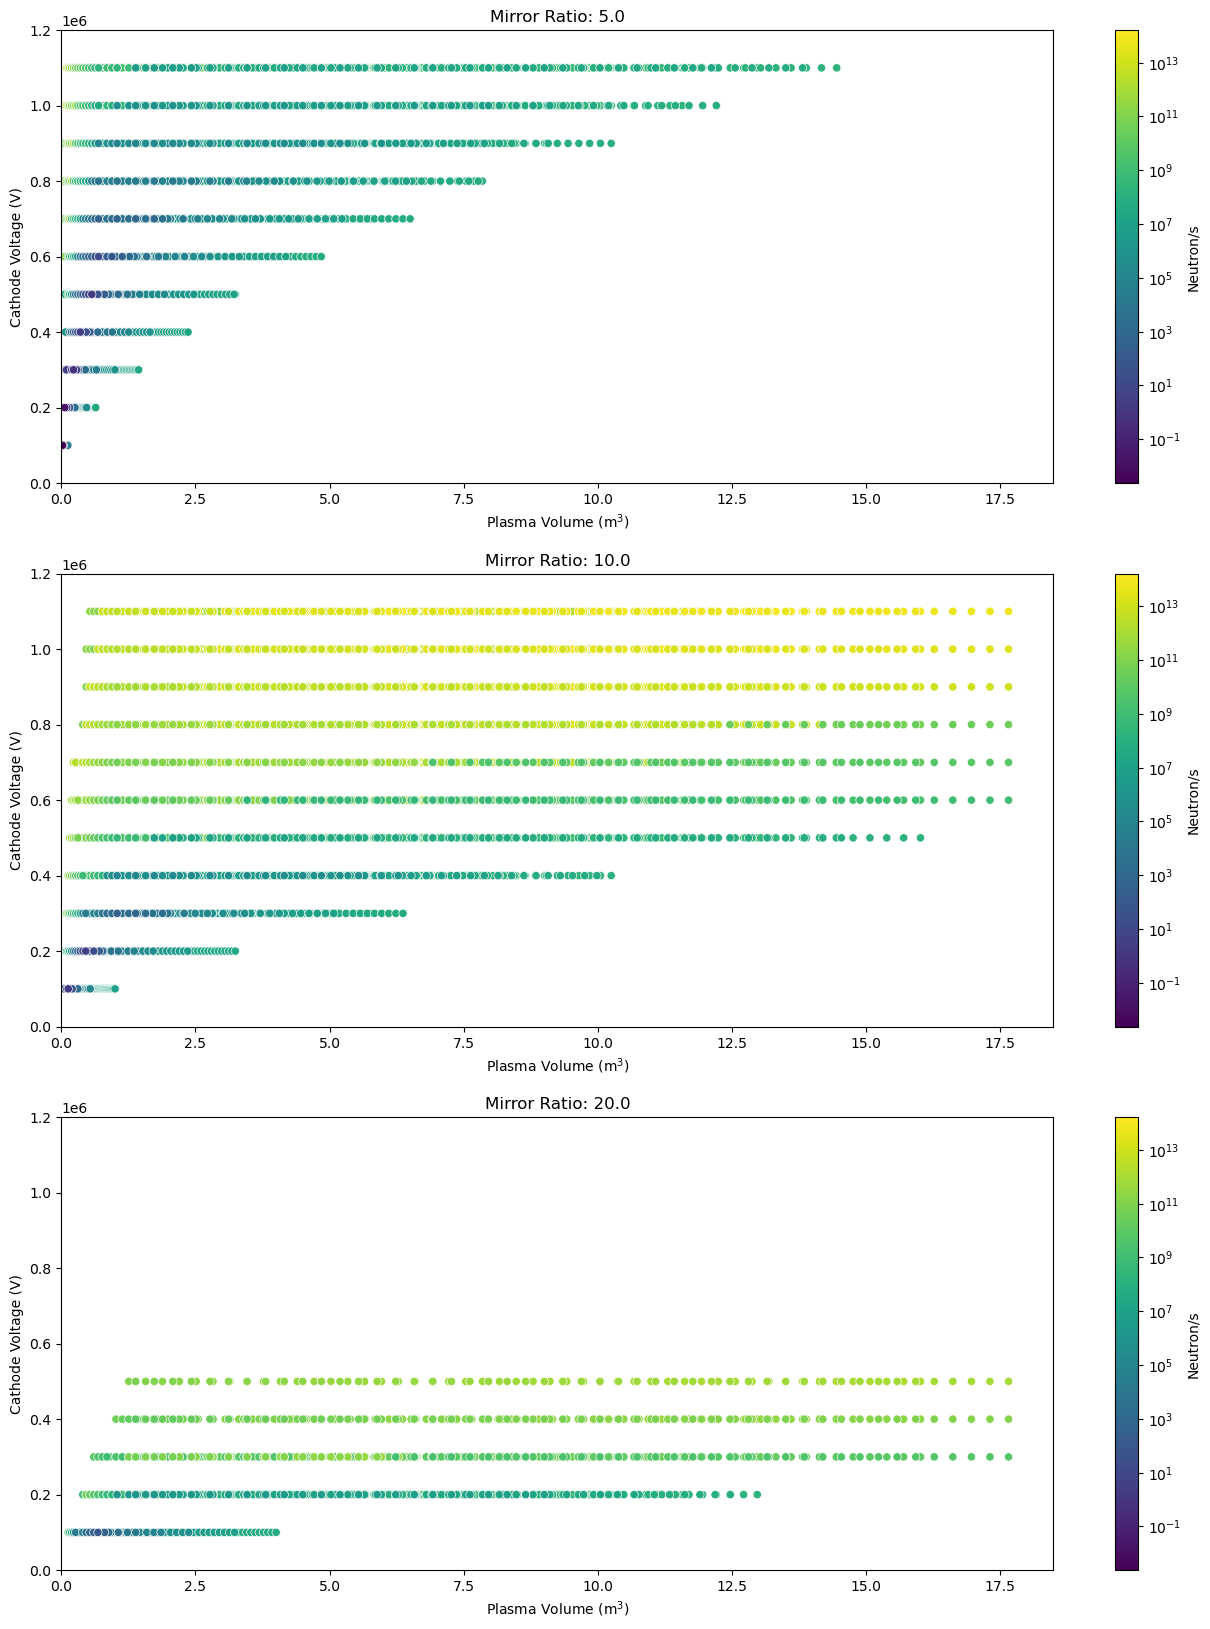

In [44]:
unique_Sweep_parameters_2_values = RhoStar_filtered_results_df['Sweep_parameters_value_2'].unique()
len_unique_Sweep_parameters_2_values = len(unique_Sweep_parameters_2_values)
Sweep_parameters_2_name = RhoStar_filtered_results_df['Sweep_parameters_name_2'].unique()[0]



mirror_ratio_df_5 = aspect_ratio_filtered_results_df.where(aspect_ratio_filtered_results_df['Mirror_Ratio']==5.0)
mirror_ratio_df_5.dropna(inplace=True)
mirror_ratio_df_10 = aspect_ratio_filtered_results_df.where(aspect_ratio_filtered_results_df['Mirror_Ratio']==10.0)
mirror_ratio_df_10.dropna(inplace=True)
mirror_ratio_df_20 = aspect_ratio_filtered_results_df.where(aspect_ratio_filtered_results_df['Mirror_Ratio']==20.0)
mirror_ratio_df_20.dropna(inplace=True)

#neutron_1e14_filtered_results_df
print(results_df['IonTemperature'].max())


norm_Neutron_per_s = matplotlib.colors.LogNorm(vmin=aspect_ratio_filtered_results_df["neutrons_per_second"].min(), vmax=aspect_ratio_filtered_results_df["neutrons_per_second"].max())

fig, ax = plt.subplots(3,1)
fig.set_figwidth(16)
fig.set_figheight(20)

mirror_ratio_5_scatter = seaborn.scatterplot(data=mirror_ratio_df_5,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[0], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
mirror_ratio_10_scatter = seaborn.scatterplot(data=mirror_ratio_df_10,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[1], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
mirror_ratio_20_scatter = seaborn.scatterplot(data=mirror_ratio_df_20,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[2], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)

sm = matplotlib.cm.ScalarMappable(cmap="viridis", norm=norm_Neutron_per_s)
sm.set_array([])

plt.colorbar(sm, ax=ax[0], label="Neutron/s")
plt.colorbar(sm, ax=ax[1], label="Neutron/s")
plt.colorbar(sm, ax=ax[2], label="Neutron/s")


ax[0].set_xlabel('Plasma Volume (m$^3$)')
ax[0].set_ylabel('Cathode Voltage (V)')
ax[0].set_title('Mirror Ratio: 5.0')
ax[0].set_xlim([0,18.5])
ax[0].set_ylim([0,1.2e6])
# ax[0].set_ylim([0,320e3])
# ax[0].set_xscale('log')
ax[0].get_legend().remove()

ax[1].set_xlabel('Plasma Volume (m$^3$)')
ax[1].set_ylabel('Cathode Voltage (V)')
ax[1].set_title('Mirror Ratio: 10.0')
ax[1].set_xlim([0,18.5])
ax[1].set_ylim([0,1.2e6])
# ax[1].set_xscale('log')
# ax[1].set_ylim([0,320e3])
ax[1].get_legend().remove()

ax[2].set_xlabel('Plasma Volume (m$^3$)')
ax[2].set_ylabel('Cathode Voltage (V)')
ax[2].set_title('Mirror Ratio: 20.0')
ax[2].set_xlim([0,18.5])
ax[2].set_ylim([0,1.2e6])
# ax[2].set_xscale('log')
# ax[2].set_ylim([0,320e3])
ax[2].get_legend().remove()

# print(aiiaia)
plt.savefig(f'{output_filepath}/results_for_Matt.png')
# IonCollisionality
# V_plasma

0.01
0.1
1.0


/tmp/ipykernel_172295/652616417.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  mirror_ratio_10_scatter = seaborn.scatterplot(data=mirror_ratio_df_10,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[1], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
/tmp/ipykernel_172295/652616417.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  mirror_ratio_20_scatter = seaborn.scatterplot(data=mirror_ratio_df_20,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[2], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)


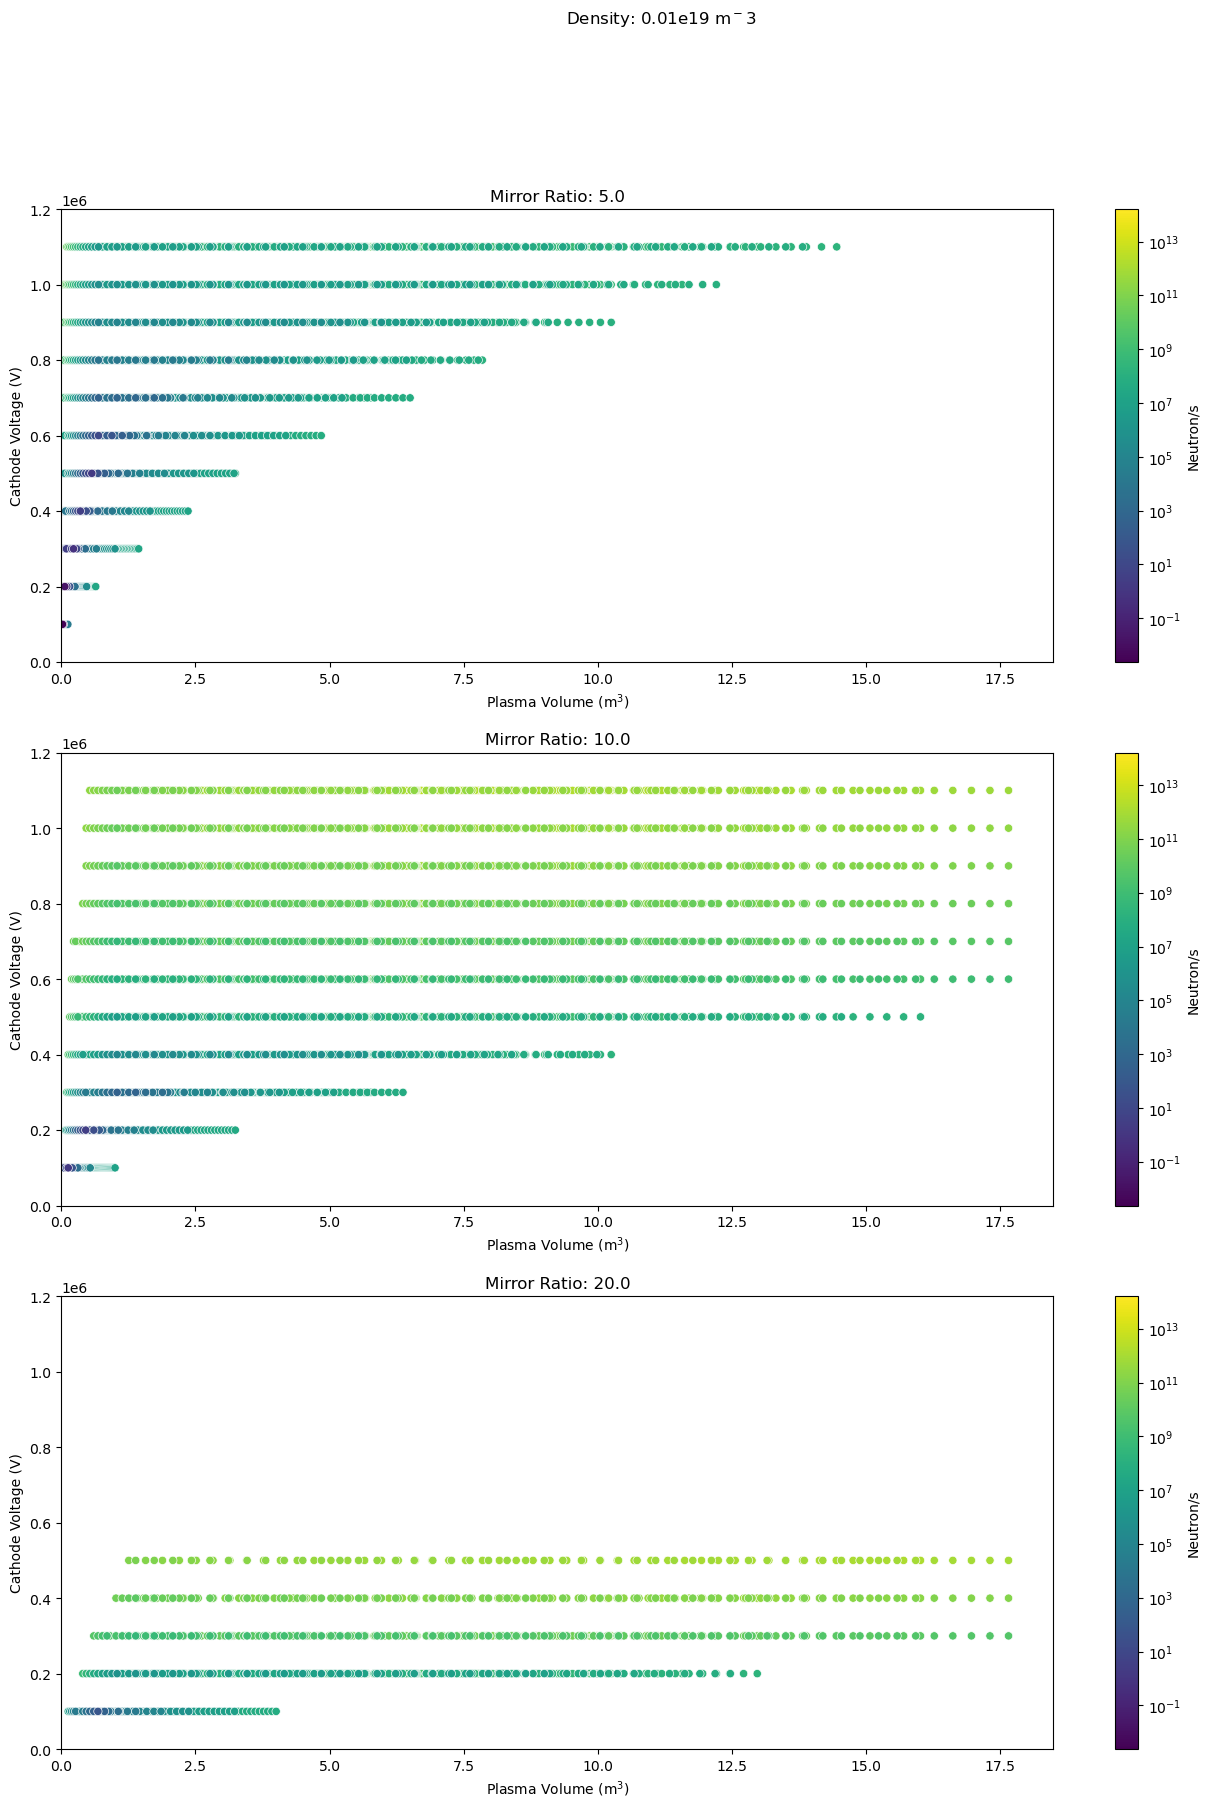

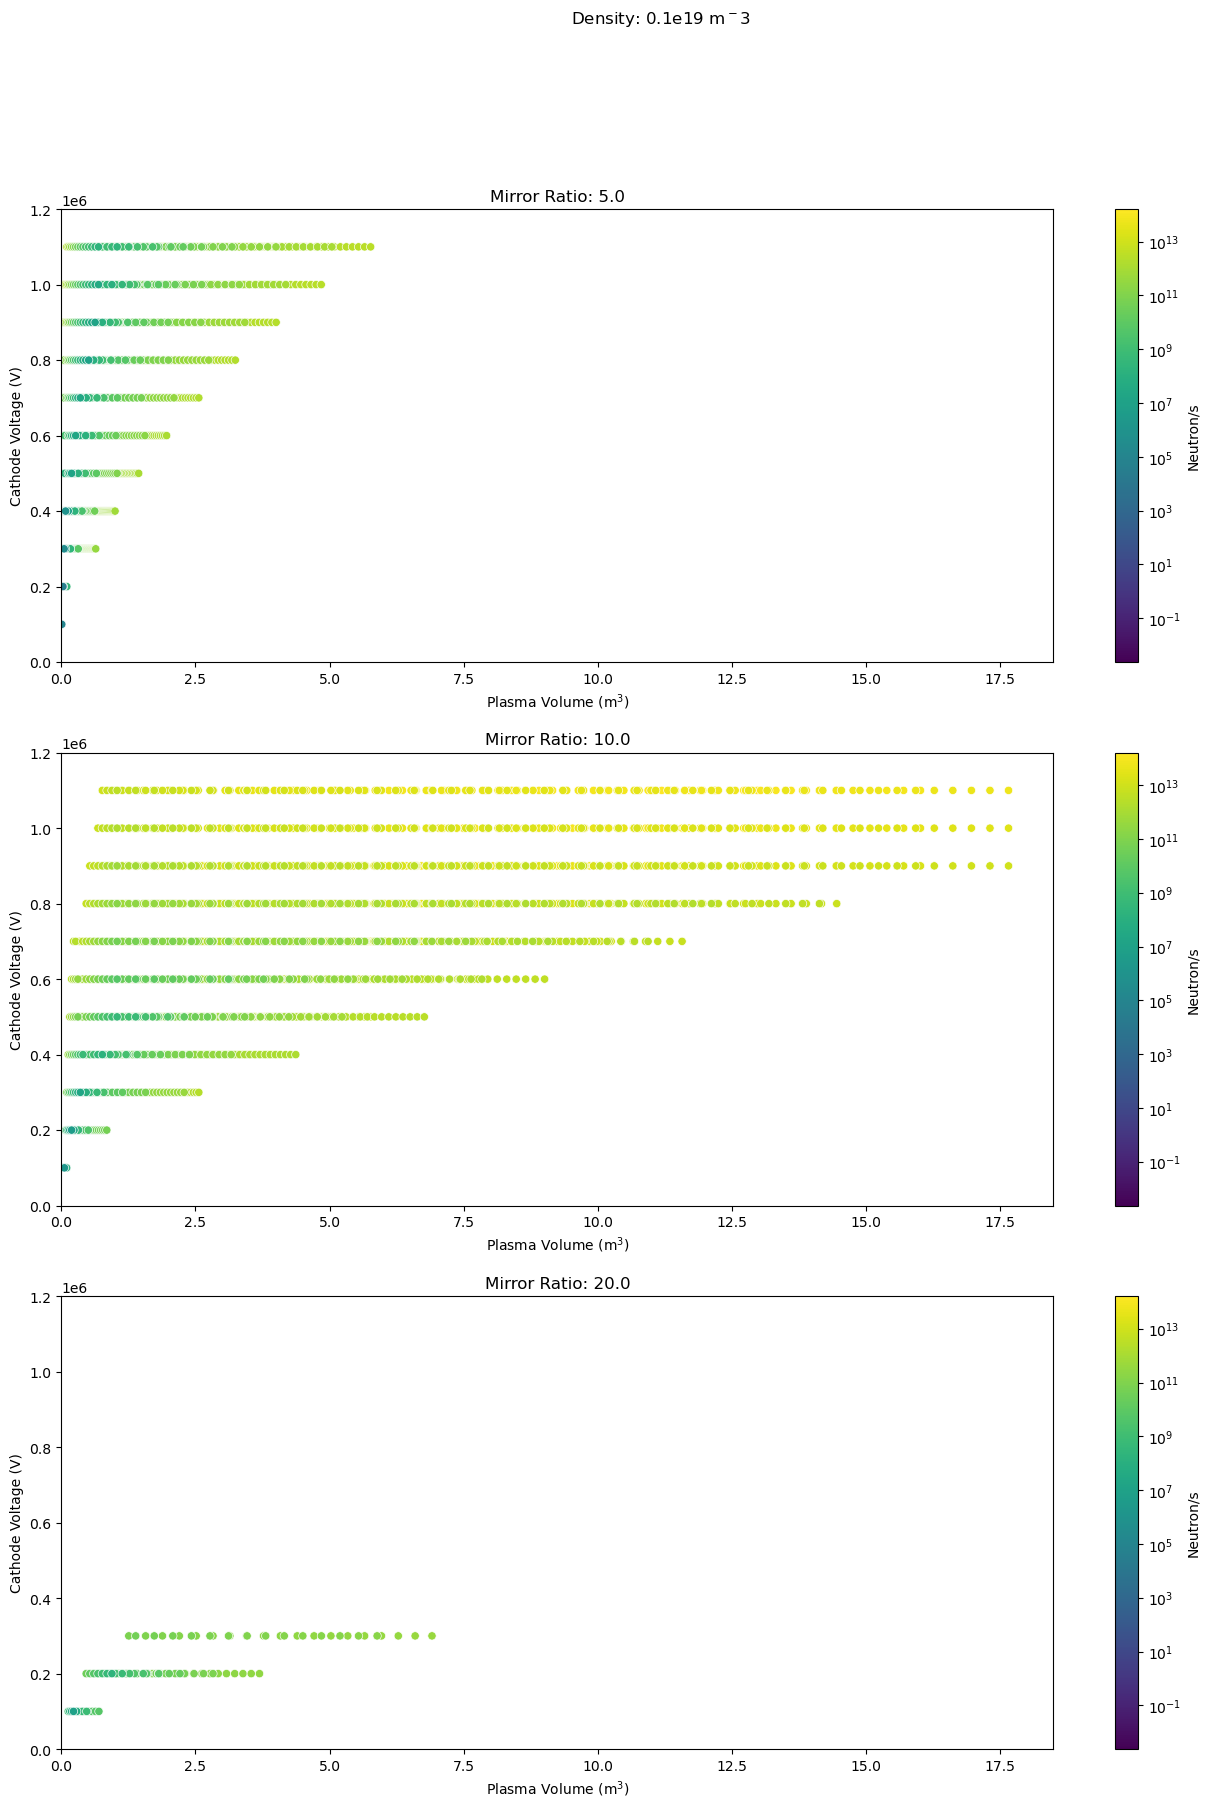

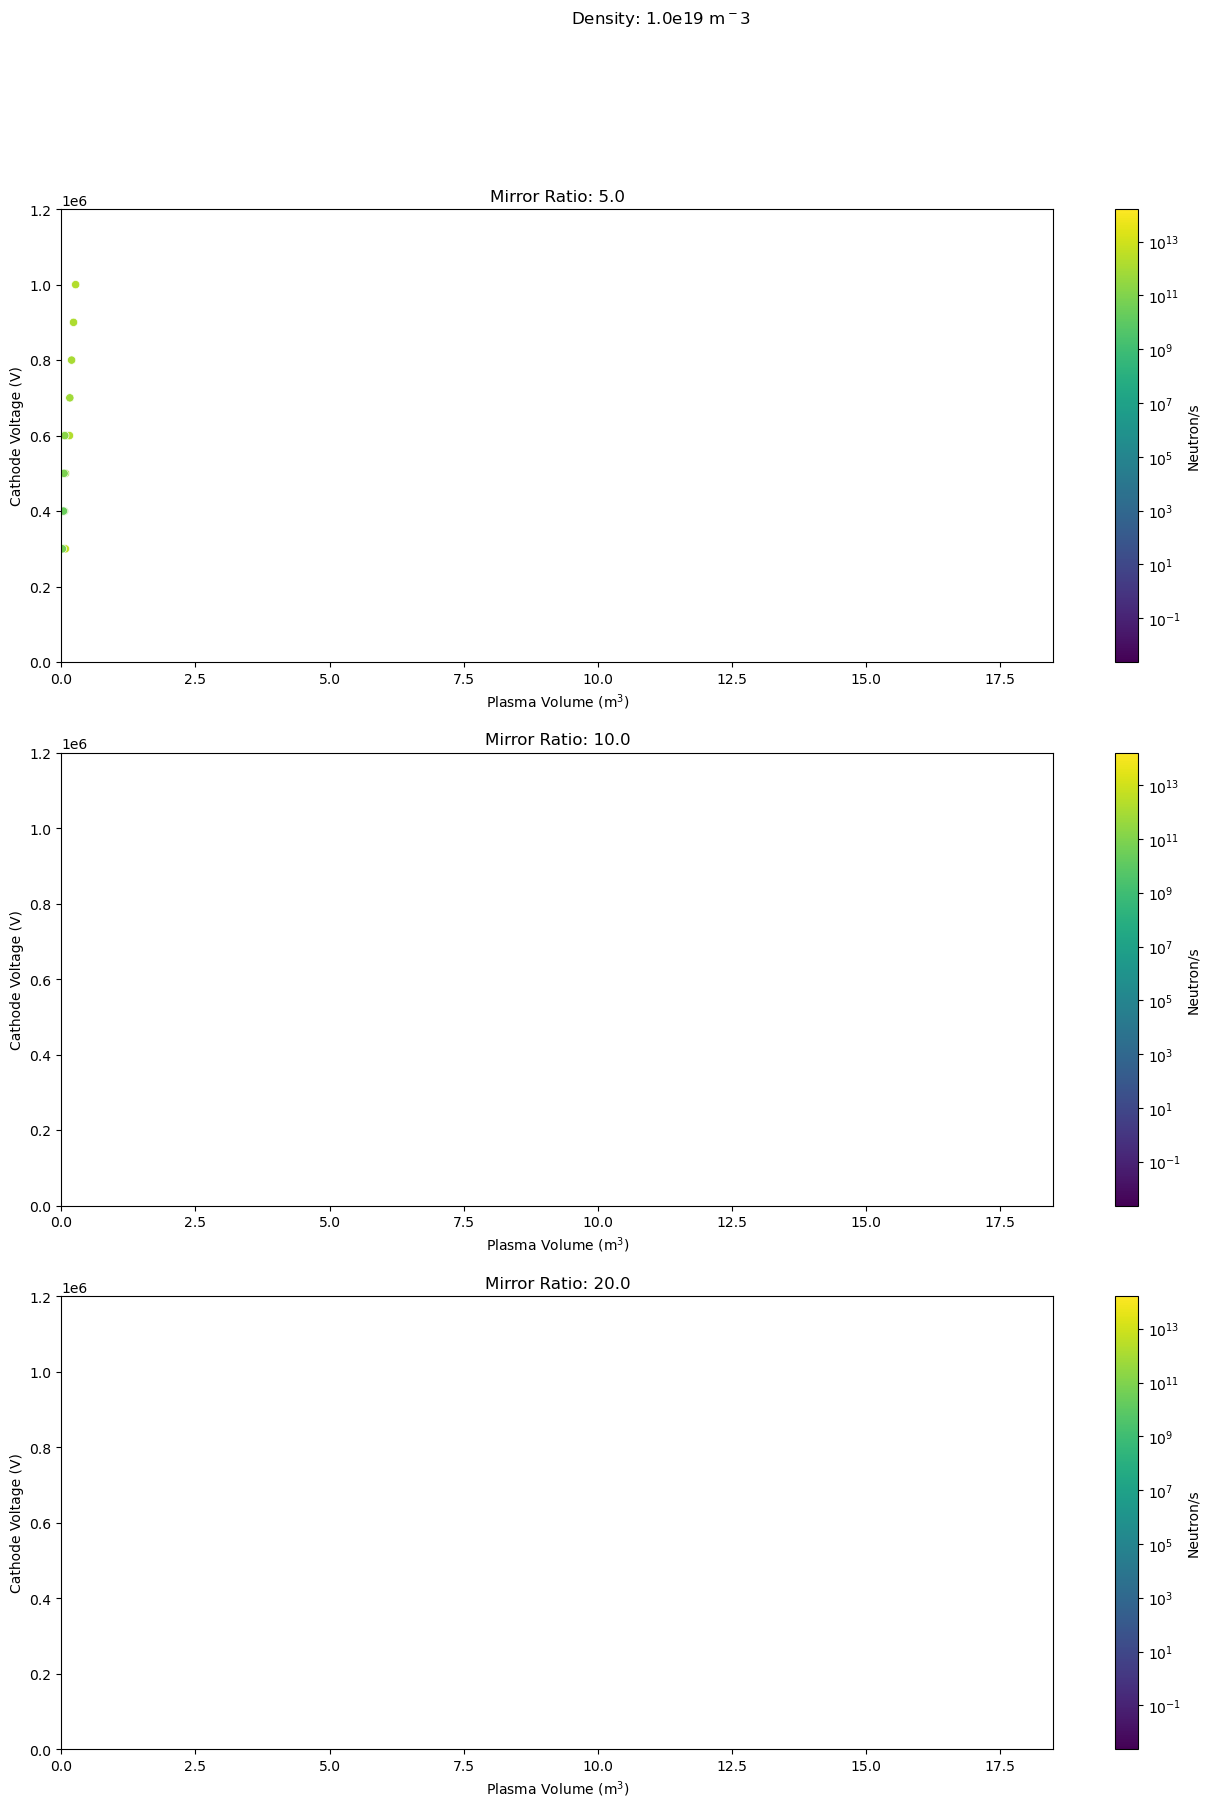

In [64]:
unique_Sweep_parameters_5_values = aspect_ratio_filtered_results_df['Sweep_parameters_value_5'].unique()
len_unique_Sweep_parameters_5_values = len(unique_Sweep_parameters_5_values)
Sweep_parameters_5_name = aspect_ratio_filtered_results_df['Sweep_parameters_name_5'].unique()[0]

# print(aspect_ratio_filtered_results_df['Sweep_parameters_value_5'])
# print(unique_Sweep_parameters_5_values)

norm_Neutron_per_s = matplotlib.colors.LogNorm(vmin=aspect_ratio_filtered_results_df["neutrons_per_second"].min(), vmax=aspect_ratio_filtered_results_df["neutrons_per_second"].max())

for den_vals in unique_Sweep_parameters_5_values:
    print(den_vals)
    this_den_val_df = aspect_ratio_filtered_results_df.where(aspect_ratio_filtered_results_df['Sweep_parameters_value_5']==den_vals)
    this_den_val_df.dropna(inplace=True)
    
    mirror_ratio_df_5 = this_den_val_df.where(this_den_val_df['Mirror_Ratio']==5.0)
    mirror_ratio_df_5.dropna(inplace=True)
    mirror_ratio_df_10 = this_den_val_df.where(this_den_val_df['Mirror_Ratio']==10.0)
    mirror_ratio_df_10.dropna(inplace=True)
    mirror_ratio_df_20 = this_den_val_df.where(this_den_val_df['Mirror_Ratio']==20.0)
    mirror_ratio_df_20.dropna(inplace=True)
    
    #neutron_1e14_filtered_results_df    
    
    fig, ax = plt.subplots(3,1)
    fig.set_figwidth(16)
    fig.set_figheight(20)
    fig.suptitle(f'Density: {den_vals}e19 m$^{-3}$')
    
    mirror_ratio_5_scatter = seaborn.scatterplot(data=mirror_ratio_df_5,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[0], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
    mirror_ratio_10_scatter = seaborn.scatterplot(data=mirror_ratio_df_10,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[1], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
    mirror_ratio_20_scatter = seaborn.scatterplot(data=mirror_ratio_df_20,x='V_plasma',y='Sweep_parameters_value_1', ax=ax[2], hue='neutrons_per_second', palette='viridis', hue_norm=norm_Neutron_per_s)
    
    sm = matplotlib.cm.ScalarMappable(cmap="viridis", norm=norm_Neutron_per_s)
    sm.set_array([])
    
    plt.colorbar(sm, ax=ax[0], label="Neutron/s")
    plt.colorbar(sm, ax=ax[1], label="Neutron/s")
    plt.colorbar(sm, ax=ax[2], label="Neutron/s")
    
    
    ax[0].set_xlabel('Plasma Volume (m$^3$)')
    ax[0].set_ylabel('Cathode Voltage (V)')
    ax[0].set_title('Mirror Ratio: 5.0')
    ax[0].set_xlim([0,18.5])
    ax[0].set_ylim([0,1.2e6])
    # ax[0].set_ylim([0,320e3])
    # ax[0].set_xscale('log')
    if ax[0].get_legend():
        ax[0].get_legend().remove()
    
    ax[1].set_xlabel('Plasma Volume (m$^3$)')
    ax[1].set_ylabel('Cathode Voltage (V)')
    ax[1].set_title('Mirror Ratio: 10.0')
    ax[1].set_xlim([0,18.5])
    ax[1].set_ylim([0,1.2e6])
    # ax[1].set_xscale('log')
    # ax[1].set_ylim([0,320e3])
    if ax[1].get_legend():
        ax[1].get_legend().remove()
    
    ax[2].set_xlabel('Plasma Volume (m$^3$)')
    ax[2].set_ylabel('Cathode Voltage (V)')
    ax[2].set_title('Mirror Ratio: 20.0')
    ax[2].set_xlim([0,18.5])
    ax[2].set_ylim([0,1.2e6])
    # ax[2].set_xscale('log')
    # ax[2].set_ylim([0,320e3])
    if ax[2].get_legend():
        ax[2].get_legend().remove()
    
    # print(aiiaia)
    plt.savefig(f'{output_filepath}/results_for_Matt_Neutron_per_second_{den_vals}_density.png')
# IonCollisionality
# V_plasma

In [ ]:
Sweep_parameters = [(1e1 + i*1000) for i in range(301)]
Sweep_parameters = numpy.round(Sweep_parameters,decimals=6)
# Sweep_parameters = [numpy.round((0.005 + i*0.00005),decimals=6) for i in range(1000)]
# Sweep_parameters = [0.1 + i*0.01 for i in range(256)]

print(Sweep_parameters)

output_filepath = pathlib.Path('Geordi_studies') / Study_name / Study_sweep_variable
output_filepath.mkdir(parents=True, exist_ok=True)


for i, param in enumerate(Sweep_parameters):
    base_config['configuration'][Study_sweep_variable] = str(param)
    specific_output_filepath = pathlib.Path(output_filepath) / f'{str(param)}_{Study_sweep_variable}_run_{i}'
    specific_output_filepath.mkdir(parents=True, exist_ok=True)
    base_config['algorithm']['AsciiOutputFile'] = f'"{home_directory_filepath}/{specific_output_filepath}/{Study_name}_{str(param)}_{Study_sweep_variable}_run_{i}.out"'
    base_config['algorithm']['NetcdfOutput'] = f'"{home_directory_filepath}/{specific_output_filepath}/{Study_name}_{str(param)}_{Study_sweep_variable}_run_{i}.nc"'
    config_file_paths_df.at[i,'FilePath'] = f'{specific_output_filepath}/{Study_name}_{str(param)}_{Study_sweep_variable}_run_{i}' #.config'
    with open(f'{specific_output_filepath}/{Study_name}_{str(param)}_{Study_sweep_variable}_run_{i}.config', 'w') as configfile:
        configfile.write('Mode = "SteadyState"\n\n')# Pre-header
        base_config.write(configfile)

In [ ]:
fig, ax = plt.subplots(8,1)
fig.set_figwidth(16)
fig.set_figheight(40)
# plt.suptitle(f'{Study_sweep_variable} Sweep')
ax[0].set_title(f'{Study_sweep_variable} Sweep')
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='AlfvenMach', ax=ax[0])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='Mach', ax=ax[1])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='IonTemperature', ax=ax[2])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='ElectronTemperature', ax=ax[3])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='Mach', ax=ax[4])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='RhoStar', ax=ax[5])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='IonCollisionality', ax=ax[6])
seaborn.scatterplot(data=results_df,x='Study Sweep Value',y='Beta', ax=ax[7])
plt.savefig(f'{output_filepath}/Quick_graph_results.png')


# ax[1].set_ylabel(f'{display_Plotting_Species} Total Power (W)')
# ax[1].set_xticks([])
# ax[1].set_xlabel(f'{display_Plotting_Species} Impact/Final Location')
# ax[1].set_yscale('log')
# ax[1].set_ylim([1e-3,10])
# plt.savefig(f'{scenario_name}/Scaled_{Plotting_Species}_boundary_Power_dist.png')
# plt.close()

In [ ]:
Ti = 94.2 #eV
mi = 1.6726219e-27 #kg
v_thi = numpy.sqrt(((2*Ti)/mi))
vstar = 0.0658 #9.98e-07
L =  0.3

vii = (vstar*v_thi)/L
print(vii)
print(1/vii)

In [ ]:
data_set = xarray.open_dataset(f'PulsedNeo_10kV_0.51T.nc')
data_set_df = data_set.to_dataframe()

print(data_set_df)

# data_set_df.to_csv(f'{output_filepath}/sweep_results.csv',index=False)

In [ ]:
fig, ax = plt.subplots(8,1)
fig.set_figwidth(16)
fig.set_figheight(40)
# plt.suptitle(f'{Study_sweep_variable} Sweep')
ax[0].set_title(f'{Study_sweep_variable} Sweep')
seaborn.scatterplot(data=data_set_df,x='t',y='Voltage', ax=ax[0])
# seaborn.scatterplot(data=data_set_df,x='t',y='AlfvenMach', ax=ax[0])
seaborn.scatterplot(data=data_set_df,x='t',y='MachNumber', ax=ax[1])
# seaborn.scatterplot(data=data_set_df,x='t',y='IonTemperature', ax=ax[2])
# seaborn.scatterplot(data=data_set_df,x='t',y='ElectronTemperature', ax=ax[3])
# seaborn.scatterplot(data=data_set_df,x='t',y='Mach', ax=ax[4])
# seaborn.scatterplot(data=data_set_df,x='t',y='RhoStar', ax=ax[5])
# seaborn.scatterplot(data=data_set_df,x='t',y='IonCollisionality', ax=ax[6])
# seaborn.scatterplot(data=data_set_df,x='t',y='Beta', ax=ax[7])

In [ ]:
tetss = numpy.arange(100e3, 1.1e6, 100e3)
print((tetss))
print(len(tetss))